##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# How to read a file that is stored in Google Drive





In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Listing files

In [3]:
!ls "./drive/My Drive/Colab Notebooks/"

 base.txt			 pietonsimage
 cnn.ipynb			 regressionlineaire.ipynb
'Copie de WR.ipynb'		'regressionlineairePEIP2 (1).ipynb'
 databaseC.csv			 regressionlineairePEIP2.ipynb
 LSTMtoRicardoPrediction.ipynb	 Untitled0.ipynb
 neuralneuronnenetwork.ipynb	 Untitled1.ipynb
 nmt_with_attention.ipynb	 WO_seq2seq_with_attention.ipynb


In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import math

#import tensorflow.compat.v1 as tf
#import tensorflow as tf
print(tf.__version__)
#tf.disable_v2_behavior()

2.3.0


# Parsing the files

The parsing functions : They are taken from the Alafate Abulimiti project (https://github.com/AlafateABULIMITI/PRD) . We can skip this part.... We assume they are ok.

In [5]:

def saveLinewithC(line):
        """
        Supplement function to build the different sets of the seq2seq model.

        :param line: one line of the csv file
        :return: ptimes_list, solved_list.

        ptimes_list: the sequence with processing time and completion time.
        solved_list: the binary sequence that can indicate the window.
        """
        ptimes = line[0].split(' ')
        ptimes_list = []
        for k in range(1, len(ptimes), 4):
            ptimes_list.append(
                [int(float(ptimes[k])), int(float(ptimes[k + 1])), int(float(ptimes[k + 2])),
                 int(float(ptimes[k + 3]))])
        solved_list = list(map(int, line[1]))

        return ptimes_list, solved_list


In [6]:

def divideDatawithC(size, num_instance):
        """
        Function can divide the data into 3 part: Training set, Test set and Validation set.

        :param txtfile: the path of the database txt file.
        :param size: size of the sequence
        :return: X_train, y_train, X_test, y_test, X_validation, y_validation
        X_train: Training set which have the initial sequence with processing time and completion time.
        y_train: Training set which have the binary sequnece that can indicate the window.
        X_test: Test set which have the initial sequence with processing time and completion time.
        y_test: Test set which have the binary sequnece that can indicate the window.
        X_validation: Validation set which have the initial sequence with processing time and completion time.
        y_validation: Validation set which have the binary sequnece that can indicate the window.

        """

        print("num_instance: " + str(num_instance))
        num_ins_test = int(num_instance * 0.2)
        num_ins_validation = num_ins_test
        num_ins_train = num_instance - num_ins_test * 2
        X_train = []
        y_train = []
        X_test = []
        y_test = []
        X_validation = []
        y_validation = []
        with open('./drive/My Drive/Colab Notebooks/databaseC.csv') as data:
            reader = csv.reader(data)
            dataSet = list(reader)
            length = len(dataSet)
            count = 0
            for line in dataSet:
                if len(line) == 1:
                    line_per_instance = 0
                    count = count + 1
                    continue
                line_per_instance += 1
                if line_per_instance < 5: # limit number of sequences per instances to 5
                  if count <= num_ins_train:
                      ptimes_list, solved_list = saveLinewithC(line)
                      X_train.append(ptimes_list)
                      y_train.append(solved_list)
                  if num_ins_train < count <= num_ins_train + num_ins_test:
                      ptimes_list, solved_list = saveLinewithC(line)
                      X_test.append(ptimes_list)
                      y_test.append(solved_list)
                  if num_ins_train + num_ins_test < count <= num_instance:
                      ptimes_list, solved_list = saveLinewithC(line)
                      X_validation.append(ptimes_list)
                      y_validation.append(solved_list)
        X_train = np.asarray(X_train)
        y_train = np.asarray(y_train)
        y_train = np.reshape(y_train, (len(y_train), size, 1))
        X_test = np.asarray(X_test)
        y_test = np.asarray(y_test)
        y_test = np.reshape(y_test, (len(y_test), size, 1))
        X_validation = np.asarray(X_validation)
        y_validation = np.asarray(y_validation)
        y_validation = np.reshape(y_validation, (len(y_validation), size, 1))
        return X_train, y_train, X_test, y_test, X_validation, y_validation



# Let us read the data

In [7]:
num_instance = 4448 # num of instances, maximum 4448 by default
jobs_size = 100 # size of jobs = size of input 

X_train, Y_train, X_test, Y_test, X_validation,Y_validation=divideDatawithC(jobs_size,num_instance)
print("X_train shape : ", X_train.shape)
print(" => ", X_train[0,0])
print("Y_train shape : ",Y_train.shape)
print(" => ", Y_train[0,0])
X_train=tf.cast(X_train,dtype=tf.float32)
Y_train=tf.cast(Y_train,dtype=tf.float32)

print("X_test shape : ", X_test.shape)
print(" => ", X_test[0,0])

print("X_validation shape : ", X_validation.shape)
print(" => ", X_validation[0,0])

mean1=1-np.mean(Y_train)
pos_weight=mean1*10
#pos_weight=(jobs_size-mean1)+1
#pos_weight=1.5+(Y_train.shape[0]*Y_train.shape[1]/np.sum(Y_train))
#pos_weight=1+(1-np.mean(Y_train))+8.2  ###Why this value ???
print(pos_weight)


num_instance: 4448
X_train shape :  (10670, 100, 4)
 =>  [ 1 30  1 31]
Y_train shape :  (10670, 100, 1)
 =>  [0]
X_test shape :  (3552, 100, 4)
 =>  [ 1 14  1 15]
X_validation shape :  (3553, 100, 4)
 =>  [ 1 19  1 20]
8.534854799509048


# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

### Create a tf.data dataset

In [8]:
EPOCHS = 2
input_tensor_train=X_train
target_tensor_train=Y_train
BUFFER_SIZE = len(input_tensor_train)
print(BUFFER_SIZE)
BATCH_SIZE = 2**6
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
print(steps_per_epoch)
unitsenc = 2**10 #128
attentionembeddingdim=unitsenc
unitsdec = attentionembeddingdim
print(unitsenc)
vocab_tar_size = 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

10670
166
1024


In [9]:
#tf.enable_eager_execution()
#tf.enable_eager_execution()

print(tf.executing_eagerly())
example_input_batch, example_target_batch = next(iter(dataset))
print(example_input_batch.shape, example_target_batch.shape)

True
(64, 100, 4) (64, 100, 1)


## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [10]:
class Encoder(tf.keras.Model):
  def __init__(self, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform'
                                   )

  def call(self, x, hidden):
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz ,self.enc_units))

In [11]:
encoder = Encoder(unitsenc, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 100, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [12]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [13]:

attention_layer = BahdanauAttention(attentionembeddingdim)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 100, 1)


In [14]:
class Decoder(tf.keras.Model):
  def __init__(self, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    #modif romain pour que le décodeur renvoie un taux de confiance
    self.fc = tf.keras.layers.Dense(vocab_tar_size,activation='sigmoid')
    
    #code original
    #self.fc = tf.keras.layers.Dense(1)
    

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    
    x = tf.concat([tf.expand_dims(context_vector, 1), tf.expand_dims(hidden, 1)], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [15]:
decoder = Decoder(unitsdec, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 1)


## Define the optimizer and the loss function

Binary cross entropy from tensorflow' source code in order to modify the loss function directly (return value from nn_sigmoid_cross_entropy_with_logits function)

links of the code below with doc : 
https://github.com/tensorflow/tensorflow/blob/v2.1.0/tensorflow/python/keras/losses.py#L348-L406
https://github.com/tensorflow/tensorflow/blob/v2.1.0/tensorflow/python/keras/backend.py#L4585-L4615
https://github.com/tensorflow/tensorflow/blob/v2.1.0/tensorflow/python/ops/nn_impl.py#L192-L239

In [16]:
import six

from tensorflow.python.distribute import distribution_strategy_context
from tensorflow.python.framework import ops
from tensorflow.python.framework import smart_cond
from tensorflow.python.framework import tensor_util
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import losses_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.utils.generic_utils import deserialize_keras_object
from tensorflow.python.keras.utils.generic_utils import serialize_keras_object
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops.losses import losses_impl
from tensorflow.python.ops.losses import util as tf_losses_util
from tensorflow.python.util.tf_export import keras_export
from tensorflow.tools.docs import doc_controls
from tensorflow.python.ops import nn_ops

class Loss(object):
  def __init__(self, reduction=losses_utils.ReductionV2.AUTO, name=None):
    losses_utils.ReductionV2.validate(reduction)
    self.reduction = reduction
    self.name = name

  def __call__(self, y_true, y_pred, sample_weight=None):
    scope_name = 'lambda' if self.name == '<lambda>' else self.name
    graph_ctx = tf_utils.graph_context_for_symbolic_tensors(
        y_true, y_pred, sample_weight)
    with K.name_scope(scope_name or self.__class__.__name__), graph_ctx:
      losses = self.call(y_true, y_pred)
      return losses_utils.compute_weighted_loss(
          losses, sample_weight, reduction=self._get_reduction())
          
  def _get_reduction(self):
      """Handles `AUTO` reduction cases and returns the reduction value."""
      if distribution_strategy_context.has_strategy() and (
          self.reduction == losses_utils.ReductionV2.AUTO or
          self.reduction == losses_utils.ReductionV2.SUM_OVER_BATCH_SIZE):
        raise ValueError(
            'Please use `tf.keras.losses.Reduction.SUM` or '
            '`tf.keras.losses.Reduction.NONE` for loss reduction when losses are '
            'used with `tf.distribute.Strategy` outside of the built-in training '
            'loops. You can implement '
            '`tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE` using global batch '
            'size like:\n```\nwith strategy.scope():\n'
            '    loss_obj = tf.keras.losses.CategoricalCrossentropy('
            'reduction=tf.keras.losses.Reduction.NONE)\n....\n'
            '    loss = tf.reduce_sum(loss_obj(labels, predictions)) * '
            '(1. / global_batch_size)\n```\nPlease see '
            'https://www.tensorflow.org/tutorials/distribute/custom_training'
            ' for more details.')

      if self.reduction == losses_utils.ReductionV2.AUTO:
        return losses_utils.ReductionV2.SUM_OVER_BATCH_SIZE
      return self.reduction


class LossFunctionWrapper(Loss):
  def __init__(self,
               fn,
               reduction=losses_utils.ReductionV2.AUTO,
               name=None,
               **kwargs):
    super(LossFunctionWrapper, self).__init__(reduction=reduction, name=name)
    self.fn = fn
    self._fn_kwargs = kwargs

  def call(self, y_true, y_pred):
    if tensor_util.is_tensor(y_pred) and tensor_util.is_tensor(y_true):
      y_pred, y_true = tf_losses_util.squeeze_or_expand_dimensions(
          y_pred, y_true)
    return self.fn(y_true, y_pred, **self._fn_kwargs)

  def get_config(self):
    config = {}
    for k, v in six.iteritems(self._fn_kwargs):
      config[k] = K.eval(v) if tf_utils.is_tensor_or_variable(v) else v
    base_config = super(LossFunctionWrapper, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

def nn_sigmoid_cross_entropy_with_logits(
    _sentinel=None,
    labels=None,
    logits=None,
    name=None):
  #nn_ops._ensure_xent_args("sigmoid_cross_entropy_with_logits", _sentinel,
  #                         labels, logits)

  #logits = ops.convert_to_tensor(logits, name="logits")
  #labels = ops.convert_to_tensor(labels, name="labels")
  #with ops.name_scope(name, "logistic_loss", [logits, labels]) as name:
  #  logits = ops.convert_to_tensor(logits, name="logits")
  #  labels = ops.convert_to_tensor(labels, name="labels")
  #  try:
  #    labels.get_shape().merge_with(logits.get_shape())
  #  except ValueError:
  #    raise ValueError("logits and labels must have the same shape (%s vs %s)" %
  #                     (logits.get_shape(), labels.get_shape()))

    
    ####Code de yaniss : pas de softmax #######
    #ratio_1 = 1.8  # les 1 pésent 0.2
    #ratio_0 = 1.2  # les 0 pésent 0.8
    
    #zeros = array_ops.zeros_like(logits, dtype=logits.dtype)
    #cond = (logits >= zeros)
    #relu_logits = array_ops.where(cond, logits, zeros)
    #neg_abs_logits = array_ops.where(cond, -logits, logits)

    #return math_ops.add(
    #    ratio_0 * (relu_logits - logits * labels),
    #    math_ops.log1p(math_ops.exp(neg_abs_logits)) * ((ratio_1-ratio_0) * labels + ratio_0),
    #    name=name)
    ####Fin Code de yaniss : pas de softmax #######


    # ---------------------------------------------------------------------------
    # CODE MODIFIED HERE !!!

    ####Code Normal  #######
    #return math_ops.add(
    #    -labels * math_ops.log1p(logits),
    #    -(1-labels) * math_ops.log1p(1-logits),
    #    name=name)
    ####Fin Code Normal  #######


    ####Code de romain, la sortie du décodeur doit être entre 0 et 1 #######
  #logits = ops.convert_to_tensor(logits, name="logits")
  #labels = ops.convert_to_tensor(labels, name="labels")

  #zeros = array_ops.zeros_like(logits, dtype=logits.dtype)
  #cond = (logits >= zeros)
  #relu_logits = array_ops.where(cond, logits, zeros)
  #neg_abs_logits = array_ops.where(cond, -logits, logits)
  #return math_ops.add(  relu_logits - logits * labels, math_ops.log1p(math_ops.exp(neg_abs_logits)),name=name)  

  #pos_weight=1+math_ops.mean(labels)
  log_weight = 1 + (pos_weight - 1) * labels
  return math_ops.add(  (1 - labels) * logits, log_weight * (math_ops.log1p(math_ops.exp(-math_ops.abs(logits))) +
  nn_ops.relu(-logits)), name=name)
  #return math_ops.add(
  #      -labels * math_ops.log1p(logits),
  #      -(1-labels) * math_ops.log1p(1-logits),
  #      name=name)
  #ratio_1 = 0.2#1.8  # les 1 pésent 0.2
  #ratio_0 = 0.8#1.2  # les 0 pésent 0.8
  #logitsclip = tf.clip_by_value(logits, clip_value_min=0.1, clip_value_max=0.9)
  #labelclip = tf.clip_by_value(labels, clip_value_min=0, clip_value_max=1)
  #val1=labels * math_ops.log1p(logits)
  #val1=-1*val1
  #val0=(1-labels) * math_ops.log1p(1-logits)
  #val0=-1*val0
  #return val1+val0
    #return math_ops.add(
     #   (-1*labels * math_ops.log1p(logitsclip))*ratio_1,
     #   (-1*(1-labels) * math_ops.log1p(1-logitsclip))*ratio_0,
     #   name=name)
    
    
    # --------------------------------------------------------------------------

def K_binary_crossentropy(target, output, from_logits=False):
  return nn_sigmoid_cross_entropy_with_logits(labels=target, logits=output)
  #if not from_logits:
  #  if (isinstance(output, (ops.EagerTensor, variables_module.Variable)) or
  #      output.op.type != 'Sigmoid'):
  #    epsilon_ = _constant_to_tensor(epsilon(), output.dtype.base_dtype)
  #    output = clip_ops.clip_by_value(output, epsilon_, 1. - epsilon_)

      # Compute cross entropy from probabilities.
  #    bce = target * math_ops.log(output + epsilon())
  #    bce += (1 - target) * math_ops.log(1 - output + epsilon())
  #    return -bce
  #  else:
  #    assert len(output.op.inputs) == 1
  #    output = output.op.inputs[0]
  

def binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0):  # pylint: disable=missing-docstring
  #y_pred = ops.convert_to_tensor(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)
  #label_smoothing = ops.convert_to_tensor(label_smoothing, dtype=K.floatx())

  #def _smooth_labels():
  #  return y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing

  #y_true = smart_cond.smart_cond(label_smoothing,
  #                               _smooth_labels, lambda: y_true)
  return K.mean(
      tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=y_pred,pos_weight=pos_weight), axis=-1)
      #nn_sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred), axis=-1)

class BinaryCrossentropy(LossFunctionWrapper):
  def __init__(self,
               from_logits=False,
               label_smoothing=0,
               reduction=losses_utils.ReductionV2.AUTO,
               name='binary_crossentropy'):
    super(BinaryCrossentropy, self).__init__(
        binary_crossentropy,
        name=name,
        reduction=reduction,
        from_logits=from_logits,
        label_smoothing=label_smoothing)
    self.from_logits = from_logits

In [17]:
from tensorflow.python.ops import math_ops

def custom_loss_function(actual, predicted):
  return -actual * math_ops.log1p(predicted) - (1-actual) * math_ops.log1p(1-predicted)

#optimizer
optimizer = tf.keras.optimizers.Adam(0.0005)

# definition of differents loss function
loss_object_0 = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, reduction='none') # Tensorflow's

loss_object_1 = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') # Tensorflow's

loss_object_2 = BinaryCrossentropy(from_logits=True, reduction='none') # Mine

def loss_function(real, pred):
  #mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object_2(real, pred)

  #mask = tf.cast(mask, dtype=loss_.dtype)
  #loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [19]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    # Teacher forcing - feeding the target as the next input
    for t in range(0, 100):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [20]:
def eval_validation(inp, targ):
  """
  Evaluate the test sequences
  """
  loss = 0
  enc_hidden = encoder.initialize_hidden_state()
  enc_out, enc_hidden = encoder(inp, enc_hidden)
  dec_hidden = enc_hidden
  

  for t in range(len(inp[0])):
    predictions, dec_hidden, attention_weights = decoder(dec_hidden, enc_out)
    loss += loss_function(targ[:, t], predictions)
    
  return loss / int(targ.shape[1])


In [21]:

dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).shuffle(BUFFER_SIZE)
dataset_test = dataset.batch(BATCH_SIZE, drop_remainder=True)


In [22]:

ls_of_loss = []
t_of_loss = []
ls_of_loss_test = []
t_of_loss_test = []

temp = 0
sum = 0

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  total_loss_test = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    sum += 1

    # train data
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    ls_of_loss.append(batch_loss)
    t_of_loss.append(sum)

    # test on validation data
    if BATCH_SIZE * (temp+1) > len(X_test):
      temp = 0

    a = tf.cast(X_test[BATCH_SIZE * (temp) : BATCH_SIZE * (temp+1)],dtype=tf.float32)
    b = Y_test[BATCH_SIZE * (temp) : BATCH_SIZE * (temp+1)]
    batch_loss_test = eval_validation(a, b)
    total_loss_test += batch_loss_test
    ls_of_loss_test.append(batch_loss_test)
    t_of_loss_test.append(sum)
    
    temp += 1

    if batch % 1 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    #if batch >= 20:
    #  break;
  
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.4283
Epoch 1 Batch 1 Loss 1.4599
Epoch 1 Batch 2 Loss 1.4515
Epoch 1 Batch 3 Loss 1.4490
Epoch 1 Batch 4 Loss 1.4498
Epoch 1 Batch 5 Loss 1.4213
Epoch 1 Batch 6 Loss 1.4214
Epoch 1 Batch 7 Loss 1.4340
Epoch 1 Batch 8 Loss 1.4259
Epoch 1 Batch 9 Loss 1.4353
Epoch 1 Batch 10 Loss 1.4309
Epoch 1 Batch 11 Loss 1.3994
Epoch 1 Batch 12 Loss 1.4176
Epoch 1 Batch 13 Loss 1.3994
Epoch 1 Batch 14 Loss 1.4155
Epoch 1 Batch 15 Loss 1.4077
Epoch 1 Batch 16 Loss 1.4172
Epoch 1 Batch 17 Loss 1.4114
Epoch 1 Batch 18 Loss 1.4211
Epoch 1 Batch 19 Loss 1.4140
Epoch 1 Batch 20 Loss 1.4126
Epoch 1 Batch 21 Loss 1.4207
Epoch 1 Batch 22 Loss 1.4095
Epoch 1 Batch 23 Loss 1.4164
Epoch 1 Batch 24 Loss 1.4104
Epoch 1 Batch 25 Loss 1.4067
Epoch 1 Batch 26 Loss 1.4076
Epoch 1 Batch 27 Loss 1.4096
Epoch 1 Batch 28 Loss 1.4049
Epoch 1 Batch 29 Loss 1.4065
Epoch 1 Batch 30 Loss 1.4062
Epoch 1 Batch 31 Loss 1.4074
Epoch 1 Batch 32 Loss 1.4161
Epoch 1 Batch 33 Loss 1.3995
Epoch 1 Batch 34 Loss 1.

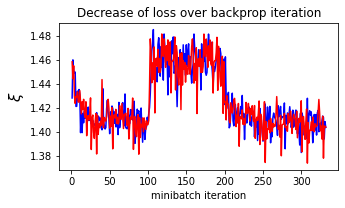

In [23]:
# Graphics of loss over time

fig = plt.figure(figsize=(5, 3))
plt.plot(t_of_loss, ls_of_loss, 'b-')
plt.plot(t_of_loss_test, ls_of_loss_test, 'r-')
plt.xlabel('minibatch iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of loss over backprop iteration')
fig.subplots_adjust(bottom=0.2)
plt.show()

In [24]:
# details of a single sequence

dataset_validation = tf.data.Dataset.from_tensor_slices((X_validation, Y_validation))
dataset_validation = dataset_validation.batch(BATCH_SIZE, drop_remainder=True)

for i in range(1):
  input_batch_validation, target_batch_validation = next(iter(dataset_validation))

  inp = tf.cast(input_batch_validation,dtype=tf.float32)
  targ = target_batch_validation[0]

  result = ''
  enc_out, enc_hidden = encoder(inp, enc_hidden)

  dec_hidden = enc_hidden
  for t in range(len(inp[0])):
    predictions, dec_hidden, attention_weights = decoder(dec_hidden, enc_out)
    #tf.keras.activations.softmax(predictions,-1)
    print(t, predictions[0].numpy(), targ[t].numpy())

0 [0.0014228] [0]
1 [0.00069607] [0]
2 [0.0001404] [0]
3 [4.5467972e-05] [0]
4 [2.7835355e-05] [0]
5 [3.3967273e-05] [0]
6 [7.302315e-05] [0]
7 [0.00022707] [0]
8 [0.00086531] [0]
9 [0.00334551] [0]
10 [0.01198577] [0]
11 [0.03960031] [0]
12 [0.11568321] [0]
13 [0.25366476] [0]
14 [0.37920624] [0]
15 [0.44025606] [0]
16 [0.4612371] [0]
17 [0.4675218] [0]
18 [0.46932238] [0]
19 [0.46983153] [0]
20 [0.469975] [0]
21 [0.4700153] [0]
22 [0.47002664] [0]
23 [0.47002986] [0]
24 [0.4700307] [0]
25 [0.47003102] [0]
26 [0.47003108] [0]
27 [0.47003114] [0]
28 [0.47003114] [0]
29 [0.47003114] [0]
30 [0.47003114] [0]
31 [0.47003114] [0]
32 [0.47003114] [0]
33 [0.47003114] [0]
34 [0.47003114] [0]
35 [0.47003114] [0]
36 [0.47003114] [0]
37 [0.47003114] [0]
38 [0.47003114] [0]
39 [0.47003114] [0]
40 [0.47003114] [0]
41 [0.47003114] [0]
42 [0.47003114] [0]
43 [0.47003114] [0]
44 [0.47003114] [0]
45 [0.47003114] [0]
46 [0.47003114] [0]
47 [0.47003114] [0]
48 [0.47003114] [0]
49 [0.47003114] [1]
50 [0.4

## Restore the latest checkpoint and test

In [25]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))